In [ ]:
%matplotlib inline

import numpy as np
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg19
from keras import backend as K

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

import cv2

import matplotlib.pyplot as plt

# Get Image Helper Functions

For this model, we will require 2 unique images: the target image, whose content we want to keep, and the style image whose style we want to use. We will use the target image as our starting point for our combined image, since content is harder to generate than style. In order to effectively fit the vgg model we will be using for the style transfer, we need a preproccessing function for when we load the image as well as a deprocessing function to reshape the image into a readable format

Helper functions to process and deprocess images

In [2]:
def preprocess_img(img_path, target_height, target_width):
    img = load_img(img_path, target_size=(target_height, target_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    
    return img
    
def deprocess_img(img):
    
    #remove ~0 centering of the vgg19 preproccessing by adding the min of each dim
    img[:,:,:,0] -= img[:,:,:,0].min() 
    img[:,:,:,1] -= img[:,:,:,1].min() 
    img[:,:,:,2] -= img[:,:,:,2].min() 
    
    # BGR to RGB
    img = img[:, :, :, ::-1]
    
    img = np.clip(img, 0, 255).astype('uint8')
    
    return img

In [3]:
width = 400
height = int(653/990 *400)

In [4]:
t_input =preprocess_img("trojanLogo.png", 653, 990 )
t_input = cv2.resize(t_input[0], (width, height))
t_input = t_input.reshape([1, height, width, 3])

In [5]:
s_input =preprocess_img("style2.jpg", 653, 990 )
s_input = cv2.resize(s_input[0], (width, height))
s_input = s_input.reshape([1, height, width, 3])

# Building the Graph

For our final picture, we are trying to minimize the difference in content between our target picture and our final picture while also minimizing the difference in style between the style picture and our target picture. Because style is a very cleare feature, we will be basing our style loss function off the loss in the early activation layers of the pretrained vgg network. Because content is a much more complex, abstract feature, we will be basing our content loss function off the loss function of the higher levels of our pretrained vgg NN. Our constant inputs will be the target picture and the style picture and our variable, updated input will be our combination picture

In [6]:
#storing target and style images as placeholders for input.
#target_img = K.placeholder(shape=(1, None, None, 3), name="target_img")
#style_img = K.placeholder(shape=(1, None, None, 3), name="style_img")

#target_img = K.constant(t_input)
#style_img = K.constant(s_input)

target_img = K.placeholder(ndim=4, name='target_img')
style_img = K.placeholder(ndim=4, name='style_img')

# This placeholder will contain our generated image
combination_img = K.placeholder(ndim=4, name="combo_img")
    
input_tensor = K.concatenate([target_img,
                              style_img,
                              combination_img], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
    


# Building Loss Functions

Loss function for content -> sum of the square difference between the combination image and the target image

In [7]:
def content_loss(target_img, combination_img):
    return (K.sum(K.square(combination_img - target_img)))

Loss function for style: so to pick up the style, we evaluate the loss function using the graham matrix, which is something a smart guy discovered that measures allows for accurate comparisons of features

In [8]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    
    #multiply height and width
    size = 500*500 #style.get_shape()[1].value*style.get_shape()[2].value
    
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# Regularization Factor

The further spaced out the combo image moves from the content image, the greater the loss becomes

In [9]:
def total_variation_loss(x):
    
    img_height = x.get_shape()[1].value
    img_width = x.get_shape()[2].value
    
    #measuring difference between shifted versions of the image
    a = K.square(
        x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = K.square(
        x[:, :1, :-1, :] - x[:, :-1, 1:, :])
    
    return K.sum(K.pow(a + b, 1.25))

# Generate Loss

In [10]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Use a late block for content
content_layer = 'block5_conv2'

# Series layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# define loss
loss = K.variable(0.)

#add the contnent loss
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)

#add weighted style losses
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    
    #get style and combo
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    
    #get loss
    sl = style_loss(style_reference_features, combination_features)
    
    #add weighted loss
    loss += (style_weight / len(style_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(combination_img)


# Get Gradients and Run Optimization

The optimizer function I use requires 2 different functions as inputs to get the loss and the grads, so to save computations time, we are going to use a class to get these values once and then store them for the second function

In [23]:
#K.gradients returns a list with 1 item
grads = K.gradients(loss, combination_img)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_img, target_img, style_img], [loss, grads])

class Storage(object):
    def __init__(self, target_img, style_img): 
        self.target_img = target_img
        self.style_img = style_img
        self.h = target_img.shape[1]
        self.w = target_img.shape[2]
        
        self.loss = None
        self.grad = None
    def get_loss(self, img):
        img = img.reshape([1, self.h, self.w, 3])
        self.loss, self.grad = fetch_loss_and_grads([img, self.target_img, self.style_img])
        
        return self.loss
    
    def get_grad(self, img):
        grad = self.grad.flatten().astype('float64')
        
        #reset values
        self.loss = None
        self.grad = None
        
        return grad
        


In [62]:
def style_transfer(target_img_path, style_img_path, iterations):
    
    #get initial dims
    height, width, _ = img_to_array(load_img(target_img_path)).shape
    
    #load initial images
    target_img = preprocess_img(target_img_path, height, width)
    style_img = preprocess_img(style_img_path, height, width)
    
    #arbitrary rescaling
    height = int(height * 400/width)
    width = 400
    
    #rescaling images
    target_img = cv2.resize(target_img[0], (width, height))
    target_img = target_img.reshape([1, height, width, 3])
    style_img = cv2.resize(style_img[0], (width, height))
    style_img = style_img.reshape([1, height, width, 3])
    
    #flatten comb img so can be inputted to l-BFGS algorithm
    combo_img = target_img.copy() 
    combo_img = combo_img.flatten()
    
    #initiate class to get grads and losses
    storage = Storage(target_img, style_img)
    
    #Optimize
    for i in range(iterations):
        
        combo_img, min_val, info = fmin_l_bfgs_b(storage.get_loss, combo_img,
                                     fprime=storage.get_grad, maxfun=10)
        
        print("Loss at iteration " +str(i) + ":", str(min_val))
    
    
    #depreocess and display images
    final_image = deprocess_img(combo_img.reshape(1, height, width, 3)).reshape(height, width, 3)
    target_image = deprocess_img(target_img).reshape(height, width, 3)
    style_image = deprocess_img(style_img).reshape(height, width, 3)
    
    display_images(target_image, style_image, final_image)
    
    
    #return the final image
    return final_image


In [63]:
def display_images(target_image, style_image, final_image):
    print("Target Image")
    plt.imshow(target_image)
    plt.figure()
    
    print("Style Image")
    plt.imshow(style_image)
    plt.figure()
    
    print("Final Image")
    plt.imshow(final_image)
    
    plt.show()
    

Loss at iteration 0: 6.72371e+09
Loss at iteration 1: 1.72019e+09
Loss at iteration 2: 9.66774e+08
Target Image
Style Image
Final Image


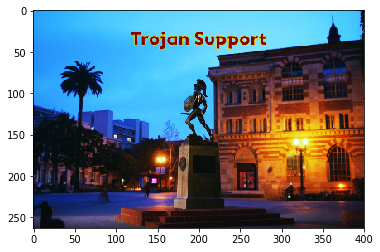

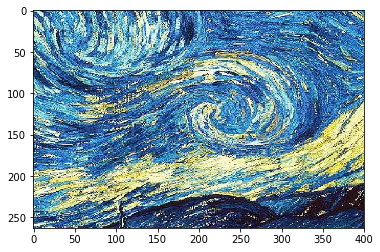

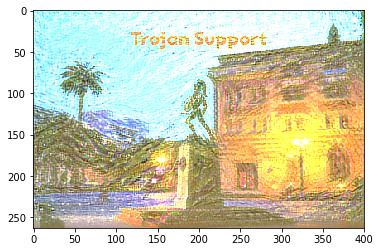

In [64]:
img = style_transfer("trojanLogo.png", "style2.jpg", 3)